In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import lag_plot
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AR
from math import sqrt

In [2]:
client = str(input("Enter Client Name : "))

Enter Client Name : jpmchase


In [4]:
le = str(input("Enter Legal Entity (eg. CitiBank Pune) : "))

Enter Legal Entity (eg. CitiBank Pune) : citibanknanewyork


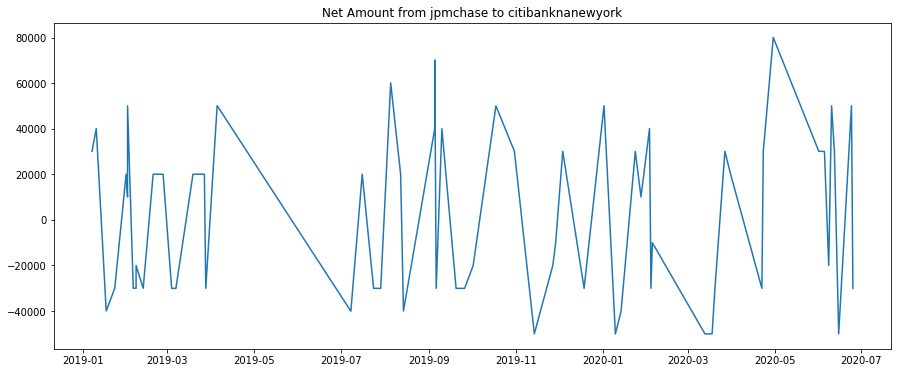

In [5]:
df = pd.read_csv(r'../processed_data.csv', parse_dates = ['Payment Date'], index_col = 'Payment Date')
ts = df[(df['Client Name'] == client) & (df['Legal Entity'] == le)]['Paid Amount']
#print(df[df['Client Name'] == 'JP Morgan'])
#print(ts)
#ts.dropna(inplace = True)
#print(len(ts))
plt.title(f'Net Amount from {client} to {le}')
plt.plot(ts)
plt.show()

Text(0.5, 1.0, 'Moving Average of the data to show the trend')

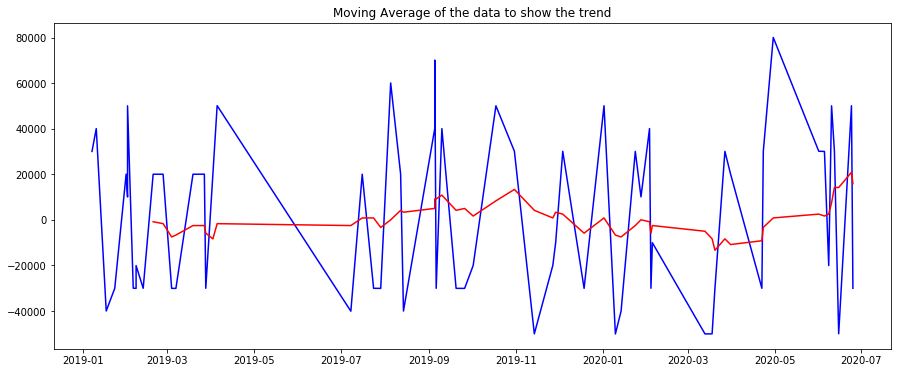

In [6]:
# Moving Average to show the trend

rolmean = ts.rolling(window=12,center=False).mean()
orig = plt.plot(ts.index.to_pydatetime(), ts.values, color='blue',label='Original')
mean = plt.plot(rolmean.index.to_pydatetime(), rolmean.values, color='red', label='Rolling Mean')
plt.title('Moving Average of the data to show the trend')

/Users/sumeetagarwal/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:4494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(result)


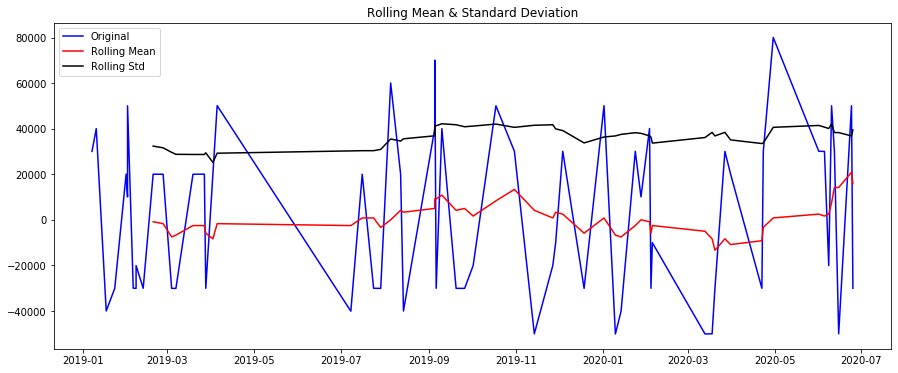

In [7]:
#Test stationarity using graphs
def test_stationarity(timeseries):
    
    timeseries.dropna(inplace = True)
    #print(len(timeseries))
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

test_stationarity(ts)

In [8]:
#Perform Dickey-Fuller test:
def df_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    pval = dfoutput['p-value']
    print(f'Result: The series is {"not " if pval > 0.05 else ""}stationary')
    
df_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                -8.484409e+00
p-value                        1.365566e-13
#Lags Used                     0.000000e+00
Number of Observations Used    6.400000e+01
Critical Value (1%)           -3.536928e+00
Critical Value (5%)           -2.907887e+00
Critical Value (10%)          -2.591493e+00
dtype: float64
Result: The series is stationary


In [9]:
# Perform KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')



In [10]:
kpss_test(ts)

KPSS Statistic: 0.10528356226028356
p-value: 0.1
num lags: 11
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/Users/sumeetagarwal/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/Users/sumeetagarwal/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [11]:
ts_log = np.log(ts)
#deal with negative values by adding a large positive constant
ts_log = np.log(ts + 100000)
ts_log.head()
len(ts_log)

/Users/sumeetagarwal/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


65

In [12]:
ts_log.dropna(inplace=True)
print(len(ts_log))

65


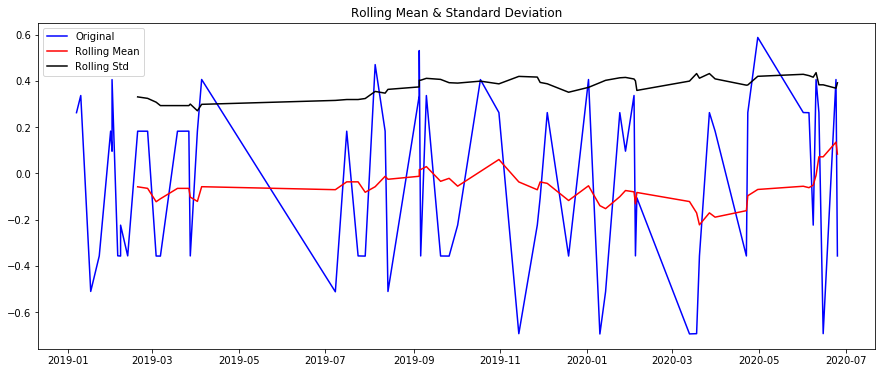

In [13]:
test_stationarity(ts_log - np.log(100000))

In [14]:
df_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                -8.445387e+00
p-value                        1.718398e-13
#Lags Used                     0.000000e+00
Number of Observations Used    6.400000e+01
Critical Value (1%)           -3.536928e+00
Critical Value (5%)           -2.907887e+00
Critical Value (10%)          -2.591493e+00
dtype: float64
Result: The series is stationary


In [15]:
# Applying differencing 
ts_log_diff = ts_log - ts_log.shift()

In [16]:
print(ts_log_diff)

Payment Date
2019-01-07         NaN
2019-01-10    0.074133
2019-01-17   -0.847519
2019-01-23    0.153429
2019-01-31    0.540235
                ...   
2020-06-10    0.629544
2020-06-12   -0.142600
2020-06-15   -0.956533
2020-06-24    1.099419
2020-06-25   -0.763201
Name: Paid Amount, Length: 65, dtype: float64


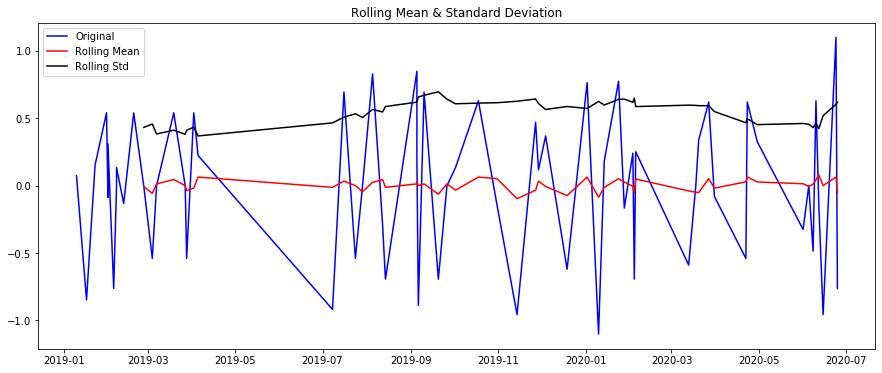

In [17]:
# test the stationarity on differenced log data
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

In [18]:
df_test(ts_log_diff)

Results of Dickey-Fuller Test:
Test Statistic                -5.857661e+00
p-value                        3.469422e-07
#Lags Used                     5.000000e+00
Number of Observations Used    5.800000e+01
Critical Value (1%)           -3.548494e+00
Critical Value (5%)           -2.912837e+00
Critical Value (10%)          -2.594129e+00
dtype: float64
Result: The series is stationary


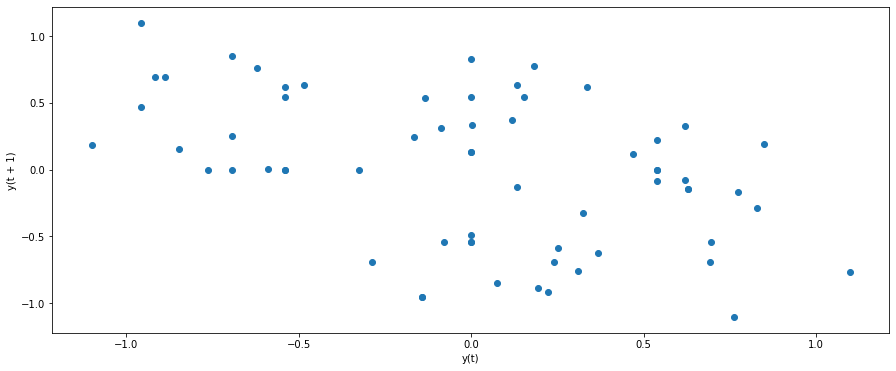

In [19]:
pd.plotting.lag_plot(ts_log_diff)
pyplot.show()

In [20]:
values = pd.DataFrame(ts_log_diff.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000 -0.445974
t+1 -0.445974  1.000000


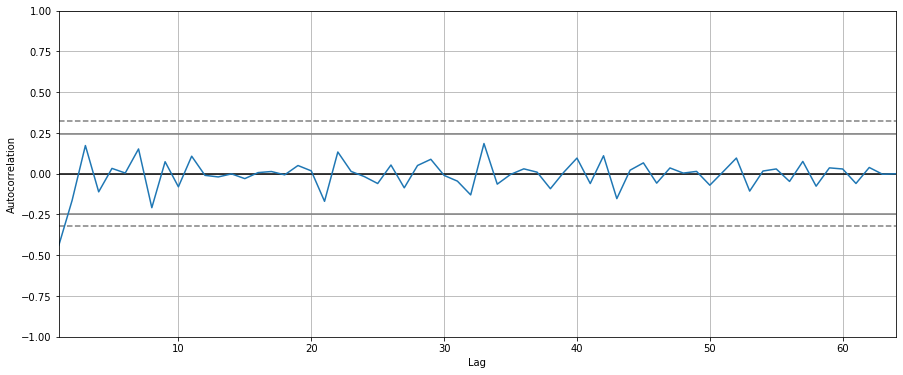

In [21]:
autocorrelation_plot(ts_log_diff)
pyplot.show()

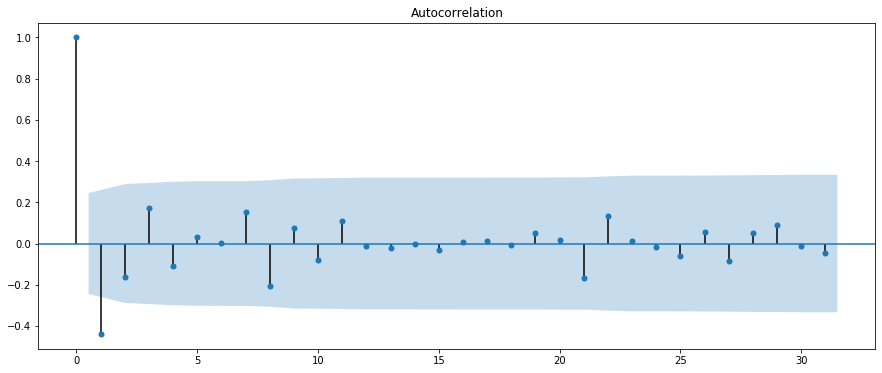

In [22]:
plot_acf(ts_log_diff, lags=31)
pyplot.show()

In [23]:
values = pd.DataFrame(ts_log_diff.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']

In [24]:
print(dataframe)

         t-1       t+1
0        NaN  0.074133
1   0.074133 -0.847519
2  -0.847519  0.153429
3   0.153429  0.540235
4   0.540235 -0.087087
..       ...       ...
59 -0.486337  0.629544
60  0.629544 -0.142600
61 -0.142600 -0.956533
62 -0.956533  1.099419
63  1.099419 -0.763201

[64 rows x 2 columns]


In [25]:
X = dataframe.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
print(test_X)

[-3.24840596e-01 -6.61284146e-04 -4.86336961e-01  6.29543947e-01
 -1.42599511e-01 -9.56532830e-01  1.09941892e+00]


In [26]:
def model_persistence(x):
    return x

-0.32484059603007864
-0.0006612841455897467
-0.486336960953647
0.6295439470914914
-0.14259951110061309
-0.9565328295844182
1.0994189204244726
Test MSE: 1.506


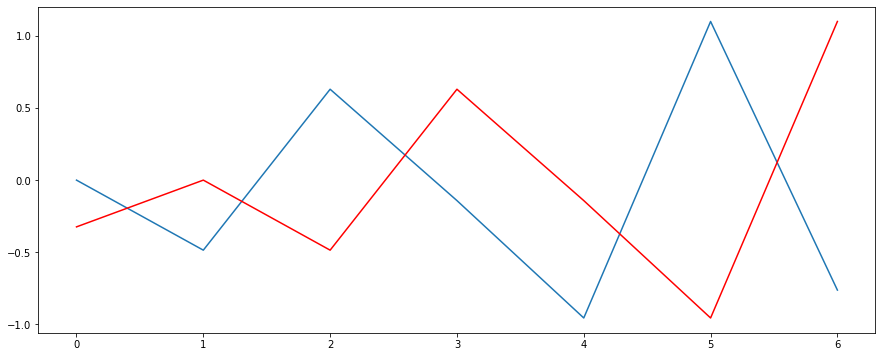

In [27]:
# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
    print(yhat)

    
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()

In [28]:
X = ts_log_diff.values

In [29]:
train, test = X[1:len(X)-7], X[len(X)-7:]

In [30]:
model = AR(train)
model_fit = model.fit()

/Users/sumeetagarwal/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN

In [31]:
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [32]:
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))

predicted=-0.670593, expected=-0.000661
predicted=0.151212, expected=-0.486337
predicted=-0.270920, expected=0.629544
predicted=0.019558, expected=-0.142600
predicted=0.650048, expected=-0.956533
predicted=0.102099, expected=1.099419
predicted=-0.131040, expected=-0.763201


In [33]:
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.900


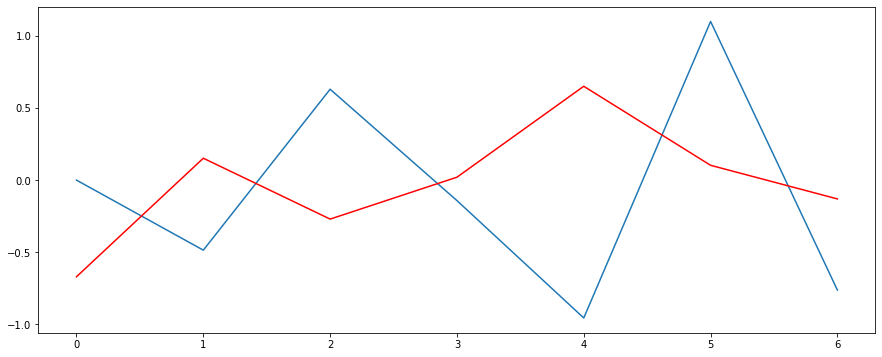

In [34]:
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [35]:
print('Coefficients: %s' % model_fit.params)

Coefficients: [ 0.00577894 -0.84384175 -1.08946295 -0.92737987 -1.06590934 -1.08892487
 -1.01459067 -0.75189981 -0.93527463 -0.55544954 -0.50991784]
